# Common Spatial File Formats

```{admonition} Summary
:class: hint

This section explains XY common spatial file formats.

- JSON
- Shapefiles (.shp)


```

Let's continue from the previous section by referencing our example data.

In [81]:
from pathlib import Path

INPUT = Path.cwd().parents[0] / "00_data"
mydata = INPUT / "Biotopwerte_Dresden_2028.geojson"

Using `pathlib`, the size of the files are accessible:
- `stat`: Returns information about the file
- `st_size`: Extracts the size of the file from information, in bytes

In [82]:
size = mydata.stat().st_size
size

82371724

Convert it to Megabyte, and format to showing two decimals by using f-strings.

- `f'`: Put variables inside {}
- `:f`: Treats the value as a float
- `:.2f`: Rounds the number to 2 decimal places

In [83]:
size_gb = size / 1024 / 1024
print(f'{size_gb:.2f} MB')

78.56 MB


## JSON Format

For retriving a json files, the [json package](https://docs.python.org/3/library/json.html) is suitable.

In [84]:
import json

To access the content the following code is used:
- `with`: Ensures the file is properly closed after reading
- `open`: Opens the file for reading
- `load`: Reads the file (source) and parses the contents of the JSON file into `data` variable, as a Python dictionary or list, depending on the JSON structure.

In [85]:
with mydata.open() as source:
    data = json.load(source)

Below, preview the json:

`````{admonition} Print!
:class: danger

For printing the content of the data `print` is used but if the data is too large it will show the following error:

```{figure} ../resources/10.png
:width: 700px
:name: figure-example

Printing error for large datasets
```
`````

**!** In this case it is better to print just some subset of the data.

- `indent=2` will prettify the output
- `[0:200]` limits output to the first `200` characters

In [86]:
print(json.dumps(data, indent=2)[0:200])

{
  "displayFieldName": "",
  "fieldAliases": {
    "FID": "FID",
    "CLC_st1": "CLC_st1",
    "Biotpkt201": "Biotpkt201",
    "Shape_Leng": "Shape_Leng",
    "Shape_Area": "Shape_Area"
  },
  "geome


Often, a better way is to use the [Pandas library](https://pandas.pydata.org/) for viewing and working with data.

In [87]:
import pandas as pd

- Preview the top-level json structure using `pd.json_normalize()`.
- Transpose the view using `.T`, similar to Excel

In [88]:
pd.json_normalize(data, errors="ignore").T

,0
displayFieldName,
geometryType,esriGeometryPolygon
fields,"[{'name': 'FID', 'type': 'esriFieldTypeOID', '..."
features,"[{'attributes': {'FID': 0, 'CLC_st1': '122', '..."
fieldAliases.FID,FID
fieldAliases.CLC_st1,CLC_st1
fieldAliases.Biotpkt201,Biotpkt201
fieldAliases.Shape_Leng,Shape_Leng
fieldAliases.Shape_Area,Shape_Area
spatialReference.wkid,25833


The type of the data can be determined using the following code:

In [89]:
print(type(data))

<class 'dict'>


If the data is a dictionary (`dict`), For visualizing only the key of the file the following code is using:

In [90]:
print(data.keys()) 

dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features'])


It is also possible to see the value of the key elements.

**ex**: below the value for the key `spatialReference` is extracted:

In [91]:
data['spatialReference']

{'wkid': 25833, 'latestWkid': 25833}

## Temporary data and ZIP files

In [96]:
import zipfile
import tempfile
import requests

In [97]:
sample_data_url = 'https://datashare.tu-dresden.de/s/KEL6bZMn6GegEW4/download'

A temporary directory is created for preventing downloading and storing the data in local system. 

The file path will be defined by joining `folder of the file` and `file name`. The [tempfile](https://docs.python.org/3/library/tempfile.html) library that comes with Python is used for this reason.

In [98]:
temp = Path(tempfile.mkdtemp())
zip_path = temp / "data.zip"

Then the request for accessing the data in the API will send and the content of the API file will be written in the temporary file.

In [99]:
response = requests.get(sample_data_url)
with open(zip_path, 'wb') as file:
    file.write(response.content)

As the content of the API file was in zip format, the zip file needs to be extracted.

In [100]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp)

Have a look what is in the `temp` folder.
- use `.glob(*)` to get a list of files. This will return a [generator](https://wiki.python.org/moin/Generators) object that can be looped over
- in order to display these files, we turn the generator into a list using `list()`

In [101]:
list(temp.glob("*"))

[PosixPath('/tmp/tmpp4ndhdpm/data.zip'),
 PosixPath('/tmp/tmpp4ndhdpm/layers'),
 PosixPath('/tmp/tmpp4ndhdpm/LBM2018IS_DD.json'),
 PosixPath('/tmp/tmpp4ndhdpm/LBM2018_IS_DD_shp - Copy'),
 PosixPath('/tmp/tmpp4ndhdpm/LBM2018_IS_DD_shp.zip'),
 PosixPath('/tmp/tmpp4ndhdpm/LBM_2018_IS_DD.gdb.zip'),
 PosixPath('/tmp/tmpp4ndhdpm/LBM_2018_IS_DD_gdb')]

## Geodatabase Format

Considering the Geodatabase as a zip format file stored in an API, For handling the HTTP requests and zip files, creating a temporary folder for preventing storing data in local system, loading the geospatial data and working with the path of the files the packages `request`, `zipfile`, `tempfile`,`geopandas` and `os`, imported.

In [102]:
import geopandas as gp

Then the same as the method mentioned in the locally stored geodatabases the file path is generated and the file loaded in the defined path. 

In [103]:
gdb_path = temp / "Biotopwerte_Dresden_2018.gdb"
gdf = gp.read_file(gdb_path)

DriverError: /tmp/tmpp4ndhdpm/Biotopwerte_Dresden_2018.gdb: No such file or directory

If there is more than one layer in the geodatabase, without defining the name of the layer, one layer by default will be added. So it is important to know which layers needed.

For this reason the `listlayers` function from the `fiona` library imported. 

In [104]:
from fiona import listlayers

Then by calling the path of the geodatabase using this function, the list of the layers are prepared.

In [105]:
layers = listlayers(gdb_path)

DriverError: /tmp/tmpp4ndhdpm/Biotopwerte_Dresden_2018.gdb: No such file or directory

And then it is possible to print them to see the layer names in the output.

In [106]:
print(layers)

['LBM2018_IS_DD']


Now the required layers are called specifically to load.

In [107]:
gdf = gp.read_file(gdb_path, layer="Biotopwerte_Dresden_2018")

DriverError: /tmp/tmpp4ndhdpm/Biotopwerte_Dresden_2018.gdb: No such file or directory

Preview the data

In [108]:
gdf.head()

,KS_IS,CLC_st1,CLC18,CLC,Biotpkt2018,Shape_Length,Shape_Area,geometry
0,SV,122,None,NaN,5.271487,210.523801,3371.947771,"MULTIPOLYGON (((415775.635 5650481.473, 415776..."
1,SV,122,None,NaN,5.271487,31.935928,50.075513,"MULTIPOLYGON (((417850.525 5650376.330, 417846..."
2,SV,122,None,NaN,5.271487,810.640513,1543.310127,"MULTIPOLYGON (((417886.917 5650544.364, 417909..."
3,SV,122,None,NaN,5.271487,24.509066,36.443441,"MULTIPOLYGON (((423453.146 5650332.060, 423453..."
4,SV,122,None,NaN,5.271487,29.937138,40.494155,"MULTIPOLYGON (((417331.434 5650889.039, 417330..."


For visualizing, the function `plot` is using which explained in the [Creating Map Chapter](https://stag.training.fdz.ioer.info/notebooks/305_mapping.html#creating-maps)

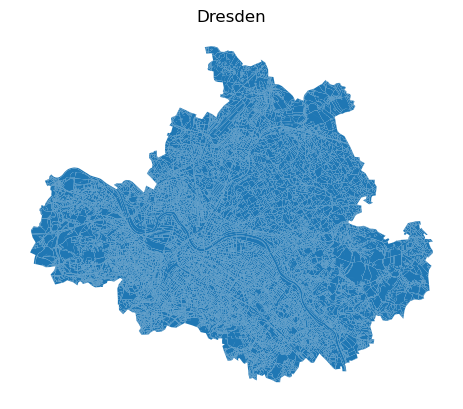

In [110]:
import matplotlib.pyplot as plt

ax = gdf.plot()
ax.set_title('Dresden')
ax.set_axis_off()

## Shapefile Format

In [ ]:
Similarly, shaprfiles can be plotted.

In [45]:
shapefile_path = INPUT / "Biotopwert_Biodiversität" / "Biotopwerte_Dresden_2018.shp"
shapes = gp.read_file(shapefile_path)

shpapes
#shp_bio.head()    for printing just the first rows of data

Select a range of features and get the bounding box.

In [78]:
lonmin, latmin, lonmax, latmax = shapes[100:110].total_bounds

- Select column `CLC_st1` for colorizing.
- limit the plot to the bounding box

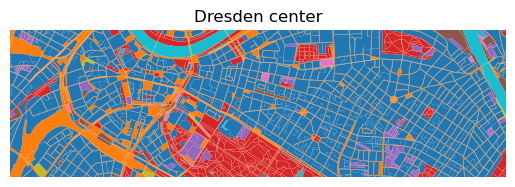

In [86]:
ax = shapes.plot(column="CLC_st1")
ax.axis([lonmin, lonmax, latmin, latmax])
ax.set_title('Dresden center')
ax.set_axis_off()

**Tabular structure**

By the means of the `geopandas`, it is possible to indicate the data as a tabular structure:

In [46]:
import geopandas as gpd

Now using the geopandas, the json file read and loads in the jupyter as GeoDataFrame.

A GeoDataFrame is a specialized data structure from the geopandas library that is designed to handle geographic data. Unlike a regular DataFrame, a GeoDataFrame can store and process spatial information, such as points, lines, and polygons, along with other attributes. This makes it ideal for loading, analyzing, and visualizing geographic data.

In [48]:
bio = gp.read_file(shapefile_path)   

After loading the data it is possible to print the data (Considering that if the data is large by defult some of the features will be printed and the size of the data is shown below the table).

In [49]:
bio

,CLC_st1,Biotpkt201,Shape_Leng,Shape_Area,geometry
0,122,5.271487,210.523801,3371.947771,"POLYGON ((415775.635 5650481.473, 415776.403 5..."
1,122,5.271487,31.935928,50.075513,"POLYGON ((417850.525 5650376.330, 417846.393 5..."
2,122,5.271487,810.640513,1543.310127,"POLYGON ((417886.917 5650544.364, 417909.326 5..."
3,122,5.271487,24.509066,36.443441,"POLYGON ((423453.146 5650332.060, 423453.576 5..."
4,122,5.271487,29.937138,40.494155,"POLYGON ((417331.434 5650889.039, 417330.611 5..."
...,...,...,...,...,...
33918,124,8.000000,9.072443,4.947409,"POLYGON ((414814.645 5666810.533, 414814.225 5..."
33919,124,8.000000,1369.670301,63201.087919,"POLYGON ((414791.962 5666543.765, 414803.055 5..."
33920,124,8.000000,395.094767,708.068118,"POLYGON ((415006.509 5666816.796, 415004.399 5..."
33921,231,10.981298,110.373766,99.282910,"POLYGON ((417478.532 5665012.465, 417477.463 5..."


For accessing to the coordinate system of the data the following code is using:

In [50]:
bio.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.42)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

For checking the head of the columns the following code is using:

In [51]:
bio.columns

Index(['CLC_st1', 'Biotpkt201', 'Shape_Leng', 'Shape_Area', 'geometry'], dtype='object')

For checking the head of the columns:

In [106]:
print(shp_bio.columns)

Index(['KS_IS', 'CLC_st1', 'CLC18', 'CLC', 'Biotpkt201', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')
